<a href="https://colab.research.google.com/github/jaredteoh/Singapore-HDB-Resale-Price-Prediction/blob/main/HDB_Resale_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The main objective of this project is to make sensible predictions of the resale prices of public housing in Singapore (using the dataset obtained from data.gov.sg). Since the location of housing (e.g., distance from the nearest mrt) is important on determining resale prices, we will derive some additional features that will aid our prediction accuracy, as we will see later.

Credits: https://medium.com/@michael.wy.ong/web-scrape-geospatial-data-analyse-singapores-property-price-part-i-276caba320b

Reference: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurelien Geron

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import math
import json
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Web-scraping Data & Exploratory Data Analysis (EDA)

The resale flat prices can be found on the data.gov.sg website. In this case, we will be using the prices from January 2017 onwards (which has been downloaded beforehand):

In [3]:
resale_price_path = '/content/drive/MyDrive/Colab Notebooks/Housing/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv'
df_resale = pd.read_csv(resale_price_path)
df_resale.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


Let's first explore the original dataset a little bit:

In [4]:
df_resale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105091 entries, 0 to 105090
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                105091 non-null  object 
 1   town                 105091 non-null  object 
 2   flat_type            105091 non-null  object 
 3   block                105091 non-null  object 
 4   street_name          105091 non-null  object 
 5   storey_range         105091 non-null  object 
 6   floor_area_sqm       105091 non-null  float64
 7   flat_model           105091 non-null  object 
 8   lease_commence_date  105091 non-null  int64  
 9   remaining_lease      105091 non-null  object 
 10  resale_price         105091 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 8.8+ MB


Here we can see that there is no missing data, so we don't have to impute it.

In [5]:
df_resale.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,105091.000000,105091.000000,1.050910e+05
mean,97.825422,1994.806853,4.523932e+05
std,24.172563,13.282782,1.569404e+05
min,31.000000,1966.000000,1.400000e+05
25%,82.000000,1985.000000,3.400000e+05
50%,95.000000,1995.000000,4.200000e+05
75%,113.000000,2004.000000,5.300000e+05
max,249.000000,2019.000000,1.268000e+06


There are only two numerical features, which is not enough to give a sensible prediction of the resale prices. We are going to derive our own numerical features later on. But first let's see the correlation of the existing numerical features with the target variable:

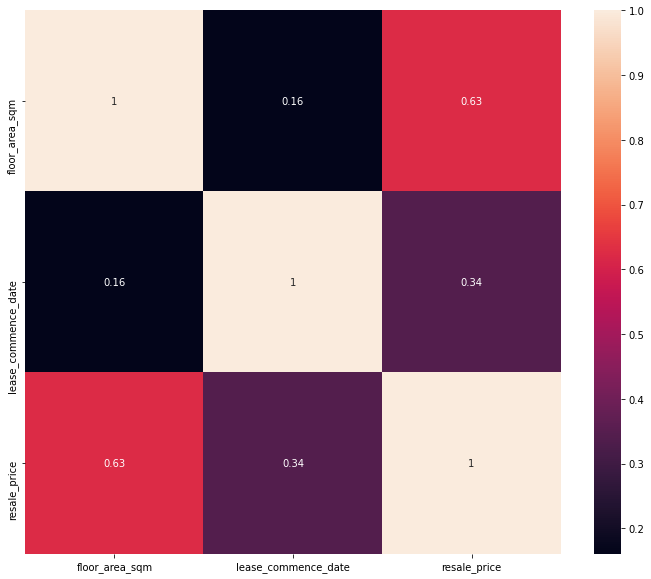

In [6]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_resale.corr(), annot=True)
plt.show()

Looks like 'floor_area_sqm' has a good positive correlation with the target variable (i.e., the resale price), whereas there is little correlation between 'lease_commence_date' with the resale price. Hence, we might consider on dropping the 'lease_commence_date' feature.

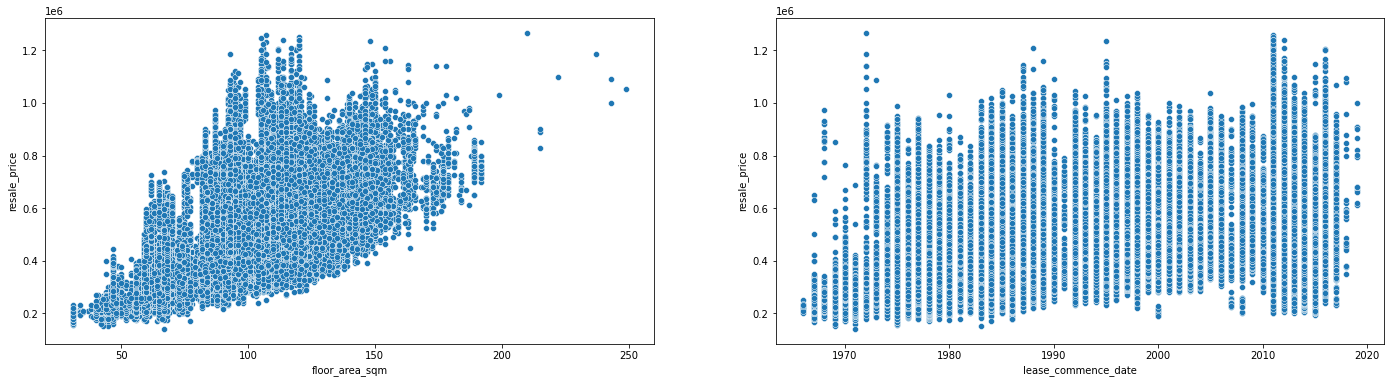

In [7]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_resale, x='floor_area_sqm', y='resale_price')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_resale, x='lease_commence_date', y='resale_price')
plt.show()

Now we will start to add our own numerical features. The first feature is the distance between the flats and their respective nearest mrt station. We will make use of onemap.sg to find the coordinates (latitude, longitude) and full addresses of the flats by using only their block and street name:

In [8]:
df_resale['address'] = df_resale['block'] + ' ' + df_resale['street_name']
df_resale.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVE 4
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVE 5
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVE 10
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVE 5


In [9]:
all_address = list(df_resale['address'])
unique_address = list(set(all_address))
print('There are {} unique addresses out of {} housing transactions.'.format(len(unique_address), len(df_resale)))

There are 9100 unique addresses out of 105091 housing transactions.


In [10]:
filepath = '/content/drive/MyDrive/Colab Notebooks/Housing/'

The function below is defined for reusability in the future on other amenities (e.g., nearest school, nearest food court). It will save the found coordinates and addresses to a csv file:

In [11]:
def find_postal(lst, filename):
    '''With the block number and street name, get the full address of the hdb flat,
    including the postal code, geogaphical coordinates (lat/long)'''
    
    for index,add in enumerate(lst):
        url= "https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal="+ add        
        if (index + 1) % 100 == 0:
          print(index + 1, url)
        
        # Retrieve information from website
        response = requests.get(url)
        data = json.loads(response.text) 
    
        temp_df = pd.DataFrame.from_dict(data["results"])
        temp_df["address"] = add
        
        # Create the file with the first row that is read in 
        if index == 0:
            file = temp_df
        else:
            file = file.append(temp_df)
    file.to_csv(filepath + filename + '.csv')

In [13]:
find_postal(lst=unique_address, filename='full_address')

100 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=276 TOH GUAN RD
200 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=312A SUMANG LINK
300 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=188B RIVERVALE DR
400 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=9 SELEGIE RD
500 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=172 BEDOK STH RD
600 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=313 UBI AVE 1
700 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=30 JLN KLINIK
800 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=308C PUNGGOL WALK
900 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDet

In [12]:
geo = pd.read_csv(filepath + 'full_address.csv')
geo.head()

,Unnamed: 0,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE,address
0,0,304 HOUGANG AVENUE 5 SINGAPORE 530304,304,HOUGANG AVENUE 5,NIL,304 HOUGANG AVENUE 5 SINGAPORE 530304,530304,34925.323729,38865.377543,1.367758,103.895547,103.895547,304 HOUGANG AVE 5
1,0,COMPASSVALE NORTH GATE,260C,SENGKANG EAST WAY,COMPASSVALE NORTH GATE,260C SENGKANG EAST WAY COMPASSVALE NORTH GATE ...,543260,34913.688262,41781.748776,1.394133,103.895444,103.895444,260C SENGKANG EAST WAY
2,0,TOWNER HEIGHTS,108C,MCNAIR ROAD,TOWNER HEIGHTS,108C MCNAIR ROAD TOWNER HEIGHTS SINGAPORE 324108,324108,30909.560487,33567.195607,1.319844,103.859462,103.859462,108C MCNAIR RD
3,0,298 BUKIT BATOK STREET 22 SINGAPORE 650298,298,BUKIT BATOK STREET 22,NIL,298 BUKIT BATOK STREET 22 SINGAPORE 650298,650298,18409.353455,36326.550736,1.344797,103.747141,103.747141,298 BT BATOK ST 22
4,0,TAMPINES GREENWOOD,868A,TAMPINES AVENUE 8,TAMPINES GREENWOOD,868A TAMPINES AVENUE 8 TAMPINES GREENWOOD SING...,521868,39042.689783,37504.164417,1.355447,103.932544,103.932544,868A TAMPINES AVE 8


In [13]:
geo.rename(columns={'Unnamed: 0': 'INDICATOR'}, inplace=True)
geo.head()

,INDICATOR,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE,address
0,0,304 HOUGANG AVENUE 5 SINGAPORE 530304,304,HOUGANG AVENUE 5,NIL,304 HOUGANG AVENUE 5 SINGAPORE 530304,530304,34925.323729,38865.377543,1.367758,103.895547,103.895547,304 HOUGANG AVE 5
1,0,COMPASSVALE NORTH GATE,260C,SENGKANG EAST WAY,COMPASSVALE NORTH GATE,260C SENGKANG EAST WAY COMPASSVALE NORTH GATE ...,543260,34913.688262,41781.748776,1.394133,103.895444,103.895444,260C SENGKANG EAST WAY
2,0,TOWNER HEIGHTS,108C,MCNAIR ROAD,TOWNER HEIGHTS,108C MCNAIR ROAD TOWNER HEIGHTS SINGAPORE 324108,324108,30909.560487,33567.195607,1.319844,103.859462,103.859462,108C MCNAIR RD
3,0,298 BUKIT BATOK STREET 22 SINGAPORE 650298,298,BUKIT BATOK STREET 22,NIL,298 BUKIT BATOK STREET 22 SINGAPORE 650298,650298,18409.353455,36326.550736,1.344797,103.747141,103.747141,298 BT BATOK ST 22
4,0,TAMPINES GREENWOOD,868A,TAMPINES AVENUE 8,TAMPINES GREENWOOD,868A TAMPINES AVENUE 8 TAMPINES GREENWOOD SING...,521868,39042.689783,37504.164417,1.355447,103.932544,103.932544,868A TAMPINES AVE 8


We will only need the address, latitude, and longitude for each flat. Note that we only preserve the rows with 'INDICATOR' == 0, since the others are repeated values:

In [14]:
geo_edited = geo.drop(columns=['SEARCHVAL', 'BLK_NO', 'ROAD_NAME', 'BUILDING', 'LONGTITUDE'])
geo_edited.head()

,INDICATOR,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,address
0,0,304 HOUGANG AVENUE 5 SINGAPORE 530304,530304,34925.323729,38865.377543,1.367758,103.895547,304 HOUGANG AVE 5
1,0,260C SENGKANG EAST WAY COMPASSVALE NORTH GATE ...,543260,34913.688262,41781.748776,1.394133,103.895444,260C SENGKANG EAST WAY
2,0,108C MCNAIR ROAD TOWNER HEIGHTS SINGAPORE 324108,324108,30909.560487,33567.195607,1.319844,103.859462,108C MCNAIR RD
3,0,298 BUKIT BATOK STREET 22 SINGAPORE 650298,650298,18409.353455,36326.550736,1.344797,103.747141,298 BT BATOK ST 22
4,0,868A TAMPINES AVENUE 8 TAMPINES GREENWOOD SING...,521868,39042.689783,37504.164417,1.355447,103.932544,868A TAMPINES AVE 8


In [15]:
geo_add_lat_long = geo_edited.copy()
geo_add_lat_long = geo_add_lat_long[geo_add_lat_long['INDICATOR'] == 0]
geo_add_lat_long.drop(columns=['INDICATOR', 'POSTAL', 'X', 'Y', 'address'], inplace=True)
geo_add_lat_long.head()

,ADDRESS,LATITUDE,LONGITUDE
0,304 HOUGANG AVENUE 5 SINGAPORE 530304,1.367758,103.895547
1,260C SENGKANG EAST WAY COMPASSVALE NORTH GATE ...,1.394133,103.895444
2,108C MCNAIR ROAD TOWNER HEIGHTS SINGAPORE 324108,1.319844,103.859462
3,298 BUKIT BATOK STREET 22 SINGAPORE 650298,1.344797,103.747141
4,868A TAMPINES AVENUE 8 TAMPINES GREENWOOD SING...,1.355447,103.932544


The list of MRT stations can be found at https://github.com/hxchua/datadoubleconfirm/blob/master/datasets/mrtsg.csv, with their latitude and longitude provided:

In [16]:
mrt_geo = pd.read_csv(filepath + 'mrtsg.csv')
mrt_geo.head()

,OBJECTID,STN_NAME,STN_NO,X,Y,Latitude,Longitude,COLOR
0,12,ADMIRALTY MRT STATION,NS10,24402.1063,46918.1131,1.440585,103.800998,RED
1,16,ALJUNIED MRT STATION,EW9,33518.6049,33190.0020,1.316433,103.882893,GREEN
2,33,ANG MO KIO MRT STATION,NS16,29807.2655,39105.7720,1.369933,103.849553,RED
3,81,BAKAU LRT STATION,SE3,36026.0821,41113.8766,1.388093,103.905418,OTHERS
4,80,BANGKIT LRT STATION,BP9,21248.2460,40220.9693,1.380018,103.772667,OTHERS


Similarly, we will drop the columns except for 'STN_NAME', 'Latitude' and 'Longitude':

In [17]:
mrt_add_lat_long = pd.DataFrame(pd.concat([mrt_geo[column] for column in ['STN_NAME', 'Latitude', 'Longitude']], axis=1))
mrt_add_lat_long.head()

,STN_NAME,Latitude,Longitude
0,ADMIRALTY MRT STATION,1.440585,103.800998
1,ALJUNIED MRT STATION,1.316433,103.882893
2,ANG MO KIO MRT STATION,1.369933,103.849553
3,BAKAU LRT STATION,1.388093,103.905418
4,BANGKIT LRT STATION,1.380018,103.772667


After determining the geographical locations, we will then define a function to find the distance from the nearest mrt stations for each flat. Again, it can be reuse for other amenities. 

In [22]:
from geopy.distance import geodesic

def find_nearest(housing, amenity):
    results = {}
    for index, flat in enumerate(housing.iloc[:, 0]):
        flat_loc = (housing.iloc[index, 1], housing.iloc[index, 2])
        flat_amenity = ['', '', 100]
        for ind, eachloc in enumerate(amenity.iloc[:, 0]):
            amenity_loc = (amenity.iloc[ind, 1], amenity.iloc[ind, 2])
            distance = geodesic(flat_loc, amenity_loc)
            if distance < flat_amenity[2]:
                flat_amenity[0] = flat
                flat_amenity[1] = eachloc
                flat_amenity[2] = distance
        results[flat] = (flat_amenity[1], flat_amenity[2])
        if (index + 1) % 100 == 0:
          print(index + 1, '-', flat, ':', results[flat])
    return results

Note that the function takes in two DataFrames with the second and third columns being the latitude and longitude of the locations (i.e., flat or MRT station). The first column could be any feature that identifies the location of its corresponding row (e.g., address of flat or name of MRT station).

In [23]:
distance_mrt = find_nearest(geo_add_lat_long, mrt_add_lat_long)

100 - 276 TOH GUAN ROAD TOH GUAN VIEW SINGAPORE 600276 : ('BUKIT BATOK MRT STATION', Distance(0.923848744213273))
200 - 312A SUMANG LINK PUNGGOL PARCVISTA SINGAPORE 821312 : ('NIBONG LRT STATION', Distance(0.11656031217058989))
300 - 188B RIVERVALE DRIVE RIVERVALE GATEWAY SINGAPORE 542188 : ('RUMBIA LRT STATION', Distance(0.3441130502392154))
400 - 9 SELEGIE ROAD SELEGIE HOUSE SINGAPORE 180009 : ('LITTLE INDIA MRT STATION', Distance(0.19657910226212602))
500 - 172 BEDOK SOUTH ROAD SIGLAP EAST SINGAPORE 460172 : ('TANAH MERAH MRT STATION', Distance(0.7431086015169406))
600 - 313 UBI AVENUE 1 KAMPONG UBI GREENVILLE SINGAPORE 400313 : ('UBI MRT STATION', Distance(0.5284994517844704))
700 - 555 CHOA CHU KANG NORTH 6 SINGAPORE 680555 : ('YEW TEE MRT STATION', Distance(0.439803630819385))
800 - 2A GEYLANG SERAI SRI GEYLANG SERAI SINGAPORE 403002 : ('PAYA LEBAR MRT STATION', Distance(0.5378829633237047))
900 - 401 TAMPINES STREET 41 SUN PLAZA GREEN SINGAPORE 520401 : ('TAMPINES MRT STATION', 

In [24]:
df_distance_mrt = pd.DataFrame(distance_mrt).T.reset_index()
df_distance_mrt

,index,0,1
0,304 HOUGANG AVENUE 5 SINGAPORE 530304,HOUGANG MRT STATION,0.5274829521956041 km
1,260C SENGKANG EAST WAY COMPASSVALE NORTH GATE ...,SENGKANG MRT STATION,0.2696330374483812 km
2,108C MCNAIR ROAD TOWNER HEIGHTS SINGAPORE 324108,BOON KENG MRT STATION,0.25161039856047973 km
3,298 BUKIT BATOK STREET 22 SINGAPORE 650298,BUKIT BATOK MRT STATION,0.541996930525703 km
4,868A TAMPINES AVENUE 8 TAMPINES GREENWOOD SING...,TAMPINES MRT STATION,1.167633244415947 km
...,...,...,...
9072,201D TAMPINES STREET 21 SINGAPORE 524201,TAMPINES EAST MRT STATION,0.44888364479729304 km
9073,312 TAMPINES STREET 33 SINGAPORE 520312,TAMPINES EAST MRT STATION,0.4977402262067574 km
9074,474 SEGAR ROAD SEGAR GARDENS SINGAPORE 670474,SEGAR LRT STATION,0.3227799730713737 km
9075,402 WOODLANDS STREET 41 SINGAPORE 730402,MARSILING MRT STATION,0.25929672103106877 km


In [25]:
df_distance_mrt = df_distance_mrt.rename(columns={'index':'ADDRESS', 0: 'MRT STATION', 1: 'DISTANCE_MRT'})
df_distance_mrt

,ADDRESS,MRT STATION,DISTANCE_MRT
0,304 HOUGANG AVENUE 5 SINGAPORE 530304,HOUGANG MRT STATION,0.5274829521956041 km
1,260C SENGKANG EAST WAY COMPASSVALE NORTH GATE ...,SENGKANG MRT STATION,0.2696330374483812 km
2,108C MCNAIR ROAD TOWNER HEIGHTS SINGAPORE 324108,BOON KENG MRT STATION,0.25161039856047973 km
3,298 BUKIT BATOK STREET 22 SINGAPORE 650298,BUKIT BATOK MRT STATION,0.541996930525703 km
4,868A TAMPINES AVENUE 8 TAMPINES GREENWOOD SING...,TAMPINES MRT STATION,1.167633244415947 km
...,...,...,...
9072,201D TAMPINES STREET 21 SINGAPORE 524201,TAMPINES EAST MRT STATION,0.44888364479729304 km
9073,312 TAMPINES STREET 33 SINGAPORE 520312,TAMPINES EAST MRT STATION,0.4977402262067574 km
9074,474 SEGAR ROAD SEGAR GARDENS SINGAPORE 670474,SEGAR LRT STATION,0.3227799730713737 km
9075,402 WOODLANDS STREET 41 SINGAPORE 730402,MARSILING MRT STATION,0.25929672103106877 km


In [26]:
df_distance_mrt.to_csv(filepath + 'distance_mrt.csv', index=False)

We will merge the result DataFrame to the original DataFrame by their corresponding address:

In [27]:
hdb = df_resale.merge(geo_edited[geo_edited['INDICATOR'] == 0], how='left', left_on='address', right_on='address')
hdb.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,INDICATOR,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10,0.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,560406,30288.234663,38229.067463,1.362005,103.853880
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVE 4,0.0,108 ANG MO KIO AVENUE 4 THE ANIMAL DOCTORS SIN...,560108,28518.183285,39217.398915,1.370943,103.837975
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVE 5,0.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,560602,28228.099954,40297.283149,1.380709,103.835368
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVE 10,0.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,560465,30657.824693,38693.098657,1.366201,103.857201
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVE 5,0.0,601 ANG MO KIO AVENUE 5 MY FIRST SKOOL SINGAPO...,560601,28201.782487,40334.051212,1.381041,103.835132


In [28]:
hdb = hdb.merge(df_distance_mrt, how='left', left_on='ADDRESS', right_on='ADDRESS')
hdb.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,INDICATOR,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,MRT STATION,DISTANCE_MRT
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10,0.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,560406,30288.234663,38229.067463,1.362005,103.853880,ANG MO KIO MRT STATION,1.0002190239027458 km
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVE 4,0.0,108 ANG MO KIO AVENUE 4 THE ANIMAL DOCTORS SIN...,560108,28518.183285,39217.398915,1.370943,103.837975,ANG MO KIO MRT STATION,1.2933927826808795 km
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVE 5,0.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,560602,28228.099954,40297.283149,1.380709,103.835368,YIO CHU KANG MRT STATION,1.0719242691470874 km
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVE 10,0.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,560465,30657.824693,38693.098657,1.366201,103.857201,ANG MO KIO MRT STATION,0.9458473209129798 km
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVE 5,0.0,601 ANG MO KIO AVENUE 5 MY FIRST SKOOL SINGAPO...,560601,28201.782487,40334.051212,1.381041,103.835132,YIO CHU KANG MRT STATION,1.094824742018516 km


In [30]:
hdb_final = hdb.drop(columns=['flat_model', 'lease_commence_date', 'remaining_lease', 'address', 'INDICATOR', 'POSTAL', 'X', 'Y', 'LATITUDE', 'LONGITUDE', 'MRT STATION'])
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.0002190239027458 km
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 THE ANIMAL DOCTORS SIN...,1.2933927826808795 km
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.0719242691470874 km
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.9458473209129798 km
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 MY FIRST SKOOL SINGAPO...,1.094824742018516 km


We will drop rows which addresses were not found from onemap.sg:

In [31]:
hdb_final[hdb_final['ADDRESS'].isnull()]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT
632,2017-01,KALLANG/WHAMPOA,3 ROOM,3,ST. GEORGE'S RD,13 TO 15,59.0,286000.0,NaN,NaN
634,2017-01,KALLANG/WHAMPOA,3 ROOM,3,ST. GEORGE'S RD,07 TO 09,59.0,320000.0,NaN,NaN
658,2017-01,KALLANG/WHAMPOA,5 ROOM,21,ST. GEORGE'S RD,07 TO 09,118.0,599000.0,NaN,NaN
1708,2017-02,KALLANG/WHAMPOA,3 ROOM,3,ST. GEORGE'S RD,10 TO 12,59.0,305000.0,NaN,NaN
1726,2017-02,KALLANG/WHAMPOA,4 ROOM,11,ST. GEORGE'S RD,07 TO 09,84.0,426800.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
104448,2021-08,KALLANG/WHAMPOA,3 ROOM,8,ST. GEORGE'S LANE,10 TO 12,68.0,380000.0,NaN,NaN
104449,2021-08,KALLANG/WHAMPOA,3 ROOM,3,ST. GEORGE'S RD,13 TO 15,59.0,310888.0,NaN,NaN
104450,2021-08,KALLANG/WHAMPOA,3 ROOM,3,ST. GEORGE'S RD,10 TO 12,70.0,360000.0,NaN,NaN
104461,2021-08,KALLANG/WHAMPOA,4 ROOM,4B,ST. GEORGE'S LANE,01 TO 03,105.0,570000.0,NaN,NaN


In [32]:
hdb_final.dropna(axis=0, inplace=True)

In [33]:
hdb_final['DISTANCE_MRT'] = hdb_final['DISTANCE_MRT'].apply(lambda x: round(x.km, 3))
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 THE ANIMAL DOCTORS SIN...,1.293
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 MY FIRST SKOOL SINGAPO...,1.095


The second self-derived feature is the distance from City Hall MRT (i.e., the city centre of Singapore) to each flat. The distance is calculated by using the find_nearest() function defined earlier:

In [34]:
citycentre_data = [['cityhall', 1.29317576, 103.8525073]]
citycentre = pd.DataFrame(citycentre_data, columns=['address', 'LATITUDE', 'LONGITUDE'])
citycentre

,address,LATITUDE,LONGITUDE
0,cityhall,1.293176,103.852507


In [35]:
distance_citycentre = find_nearest(geo_add_lat_long, citycentre)

100 - 276 TOH GUAN ROAD TOH GUAN VIEW SINGAPORE 600276 : ('cityhall', Distance(12.829979839698783))
200 - 312A SUMANG LINK PUNGGOL PARCVISTA SINGAPORE 821312 : ('cityhall', Distance(14.056790767934414))
300 - 188B RIVERVALE DRIVE RIVERVALE GATEWAY SINGAPORE 542188 : ('cityhall', Distance(12.663148990368592))
400 - 9 SELEGIE ROAD SELEGIE HOUSE SINGAPORE 180009 : ('cityhall', Distance(1.1547537290068908))
500 - 172 BEDOK SOUTH ROAD SIGLAP EAST SINGAPORE 460172 : ('cityhall', Distance(10.699986945955226))
600 - 313 UBI AVENUE 1 KAMPONG UBI GREENVILLE SINGAPORE 400313 : ('cityhall', Distance(6.9610693556349545))
700 - 555 CHOA CHU KANG NORTH 6 SINGAPORE 680555 : ('cityhall', Distance(16.633747560301558))
800 - 2A GEYLANG SERAI SRI GEYLANG SERAI SINGAPORE 403002 : ('cityhall', Distance(5.682325198617987))
900 - 401 TAMPINES STREET 41 SUN PLAZA GREEN SINGAPORE 520401 : ('cityhall', Distance(12.477032618266268))
1000 - 130 BEDOK RESERVOIR ROAD EUNOS SPRING SINGAPORE 470130 : ('cityhall', Dist

In [36]:
df_distance_citycentre = pd.DataFrame(distance_citycentre).T.reset_index()
df_distance_citycentre

,index,0,1
0,304 HOUGANG AVENUE 5 SINGAPORE 530304,cityhall,9.537072379706004 km
1,260C SENGKANG EAST WAY COMPASSVALE NORTH GATE ...,cityhall,12.143002231164408 km
2,108C MCNAIR ROAD TOWNER HEIGHTS SINGAPORE 324108,cityhall,3.0487544526248307 km
3,298 BUKIT BATOK STREET 22 SINGAPORE 650298,cityhall,13.041743011052523 km
4,868A TAMPINES AVENUE 8 TAMPINES GREENWOOD SING...,cityhall,11.258413537442541 km
...,...,...,...
9072,201D TAMPINES STREET 21 SINGAPORE 524201,cityhall,13.008798420574983 km
9073,312 TAMPINES STREET 33 SINGAPORE 520312,cityhall,13.380322858823316 km
9074,474 SEGAR ROAD SEGAR GARDENS SINGAPORE 670474,cityhall,13.817215884154134 km
9075,402 WOODLANDS STREET 41 SINGAPORE 730402,cityhall,17.670000853933246 km


In [37]:
df_distance_citycentre = df_distance_citycentre.rename(columns={'index':'ADDRESS', 0: 'LOCATION', 1: 'DISTANCE_CITYCENTRE'})
df_distance_citycentre

,ADDRESS,LOCATION,DISTANCE_CITYCENTRE
0,304 HOUGANG AVENUE 5 SINGAPORE 530304,cityhall,9.537072379706004 km
1,260C SENGKANG EAST WAY COMPASSVALE NORTH GATE ...,cityhall,12.143002231164408 km
2,108C MCNAIR ROAD TOWNER HEIGHTS SINGAPORE 324108,cityhall,3.0487544526248307 km
3,298 BUKIT BATOK STREET 22 SINGAPORE 650298,cityhall,13.041743011052523 km
4,868A TAMPINES AVENUE 8 TAMPINES GREENWOOD SING...,cityhall,11.258413537442541 km
...,...,...,...
9072,201D TAMPINES STREET 21 SINGAPORE 524201,cityhall,13.008798420574983 km
9073,312 TAMPINES STREET 33 SINGAPORE 520312,cityhall,13.380322858823316 km
9074,474 SEGAR ROAD SEGAR GARDENS SINGAPORE 670474,cityhall,13.817215884154134 km
9075,402 WOODLANDS STREET 41 SINGAPORE 730402,cityhall,17.670000853933246 km


In [38]:
df_distance_citycentre.to_csv(filepath + 'distance_citycentre.csv', index=False)

Similarly, we will merge the result DataFrame to the original DataFrame:

In [39]:
hdb_final = hdb_final.merge(df_distance_citycentre, how='left', left_on='ADDRESS', right_on='ADDRESS')
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT,LOCATION,DISTANCE_CITYCENTRE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000,cityhall,7.612266338225603 km
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 THE ANIMAL DOCTORS SIN...,1.293,cityhall,8.749844563771587 km
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072,cityhall,9.865110551058121 km
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946,cityhall,8.091639228670868 km
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 MY FIRST SKOOL SINGAPO...,1.095,cityhall,9.906290988634552 km


In [40]:
hdb_final.drop(columns=['LOCATION'], inplace=True)
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT,DISTANCE_CITYCENTRE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000,7.612266338225603 km
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 THE ANIMAL DOCTORS SIN...,1.293,8.749844563771587 km
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072,9.865110551058121 km
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946,8.091639228670868 km
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 MY FIRST SKOOL SINGAPO...,1.095,9.906290988634552 km


In [41]:
hdb_final['DISTANCE_CITYCENTRE'] = hdb_final['DISTANCE_CITYCENTRE'].apply(lambda x: round(x.km, 3))
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT,DISTANCE_CITYCENTRE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000,7.612
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 THE ANIMAL DOCTORS SIN...,1.293,8.750
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072,9.865
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946,8.092
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 MY FIRST SKOOL SINGAPO...,1.095,9.906


In [42]:
hdb_final.to_csv(filepath + 'hdb_dataset.csv', index=False)

That's all for web-scraping and EDA! Let's proceed to the next step, which is data preparation.

## Data Preparation

Before building and deploying a model for our dataset, we will need to do some prepping. We will first drop the columns 'month', 'block', 'street_name', 'ADDRESS', since they are not useful for predicting the resale price:

In [43]:
path = '/content/drive/MyDrive/Colab Notebooks/Housing/hdb_dataset.csv'
df_final = pd.read_csv(path)
df_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT,DISTANCE_CITYCENTRE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000,7.612
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 THE ANIMAL DOCTORS SIN...,1.293,8.750
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072,9.865
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946,8.092
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 MY FIRST SKOOL SINGAPO...,1.095,9.906


In [44]:
df_final.drop(columns=['month', 'block', 'street_name', 'ADDRESS'], inplace=True)
df_final.head()

,town,flat_type,storey_range,floor_area_sqm,resale_price,DISTANCE_MRT,DISTANCE_CITYCENTRE
0,ANG MO KIO,2 ROOM,10 TO 12,44.0,232000.0,1.000,7.612
1,ANG MO KIO,3 ROOM,01 TO 03,67.0,250000.0,1.293,8.750
2,ANG MO KIO,3 ROOM,01 TO 03,67.0,262000.0,1.072,9.865
3,ANG MO KIO,3 ROOM,04 TO 06,68.0,265000.0,0.946,8.092
4,ANG MO KIO,3 ROOM,01 TO 03,67.0,265000.0,1.095,9.906


In [45]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_final, random_state=42, shuffle=True, test_size=0.2)

In [46]:
X_train = df_train.drop(columns=['resale_price'])
y_train = df_train[['resale_price']]

In [47]:
X_train.shape, y_train.shape

((83887, 6), (83887, 1))

The features are split into numerical and categorical variables. They are then passed through the ColumnTransformer(), which it will preprocess the numerical and categorical variables separately, and then concetenate them. The numerical variables are scaled by using StandardScaler, whereas the categorical variables are being one-hot encoded:

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

hdb_num = X_train.select_dtypes(exclude=['object'])
hdb_cat = X_train.select_dtypes(include=['object'])

num_attribs = list(hdb_num)
cat_attribs = list(hdb_cat)

transform_pipeline = ColumnTransformer([('num', StandardScaler(), num_attribs), 
                                        ('cat', OneHotEncoder(), cat_attribs)])

X_train_prepared = transform_pipeline.fit_transform(X_train).toarray()

In [49]:
X_train_prepared[0]

array([ 0.50328456, -1.02739438,  0.34190807,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [50]:
y_train_prepared = y_train.values

In [51]:
X_train_prepared.shape, y_train_prepared.shape

((83887, 53), (83887, 1))

## Model Building

Finally, our dataset is ready for training! We will further split it into training and validation dataset:

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_prepared, y_train_prepared, test_size=0.2, random_state=42)

In [53]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((67109, 53), (16778, 53), (67109, 1), (16778, 1))

### Linear Regression

Let's start with the plain old Linear Regression:

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
from sklearn.metrics import mean_squared_error

y_pred = lin_reg.predict(X_valid)
lin_mse = mean_squared_error(y_valid, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

77101.41063314029

Let's see we can do better with added polynomial features, plus some regularization:

### Lasso Regression

In [56]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

model = Pipeline([('poly_features', PolynomialFeatures(degree=2, include_bias=False)), 
                  ('lasso', Lasso(alpha=1, tol=1e-3, random_state=42))])
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94918678654677.5, tolerance: 1647754287752.351
  positive)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
                       normalize=False, positive=False, precompute=False,
                       random_state=42, selection='cyclic', tol=0.001,
                       warm_start=False))],
         verbose=False)

In [57]:
y_pred = model.predict(X_valid)
lasso_mse = mean_squared_error(y_valid, y_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_rmse

61428.090260272984

### Decision Tree

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [59]:
y_pred = tree_reg.predict(X_valid)
tree_mse = mean_squared_error(y_valid, y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

42850.8474000905

In [60]:
y_pred = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

13850.84672617378

Looks like the model has overfitted the training data. Let's try using an ensemble of Decision Tree Regressor to trade a higher bias for lower variance.

### Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [62]:
y_pred = forest_reg.predict(X_valid)
forest_mse = mean_squared_error(y_valid, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

34651.23371316893

In [63]:
y_pred = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

17354.372910674007

It is better than the Decision Tree, but still overfits the training data. We will use GridSearchCV to tune the hyperparameters:

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [30, 40, 50], 'max_features': [30, 40, 50]},
    {'bootstrap': [False], 'n_estimators': [30, 50], 'max_features': [30, 40, 50]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [65]:
forest_reg = grid_search.best_estimator_
y_pred = forest_reg.predict(X_valid)
forest_mse = mean_squared_error(y_valid, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

34179.7951307855

In [66]:
y_pred = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

17332.803305671318

After tuning the hyperparameters, the model still overfits the training data. Let's try other ensemble methods.

### Gradient Boosting

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
gbrt.fit(X_train, y_train.ravel())

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [68]:
y_pred = gbrt.predict(X_valid)
gbrt_mse = mean_squared_error(y_valid, y_pred)
gbrt_rmse = np.sqrt(gbrt_mse)
gbrt_rmse

57963.4569677588

In [69]:
y_pred = gbrt.predict(X_train)
gbrt_mse = mean_squared_error(y_train, y_pred)
gbrt_rmse = np.sqrt(gbrt_mse)
gbrt_rmse

56663.28376587096

### XGBoost

In [70]:
import xgboost

xgb_reg = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
xgb_reg.fit(X_train, y_train.ravel())

[16:01:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [71]:
y_pred = xgb_reg.predict(X_valid)
xgb_mse = mean_squared_error(y_valid, y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

57969.765595731646

In [72]:
y_pred = xgb_reg.predict(X_train)
xgb_mse = mean_squared_error(y_train, y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

56775.40697888984

### Deep Neural Networks (DNNs)

Let's try implementing DNNs with Keras to predict the resale flat prices:

In [73]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

In [74]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train.shape[-1]))
for _ in range(20):
  model.add(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(1))

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               5400      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1

In [76]:
model.compile(loss='mse', optimizer='Adam')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('hdb_nn_model.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
2098/2098 [==============================] - 13s 4ms/step - loss: 7655420416.0000 - val_loss: 4189819136.0000
Epoch 2/100
2098/2098 [==============================] - 9s 4ms/step - loss: 4351688192.0000 - val_loss: 3899062272.0000
Epoch 3/100
2098/2098 [==============================] - 9s 4ms/step - loss: 3893050880.0000 - val_loss: 3447206656.0000
Epoch 4/100
2098/2098 [==============================] - 8s 4ms/step - loss: 3581044224.0000 - val_loss: 3357180160.0000
Epoch 5/100
2098/2098 [==============================] - 8s 4ms/step - loss: 3403307008.0000 - val_loss: 3047028736.0000
Epoch 6/100
2098/2098 [==============================] - 8s 4ms/step - loss: 3234568704.0000 - val_loss: 3052896256.0000
Epoch 7/100
2098/2098 [==============================] - 9s 4ms/step - loss: 3037198848.0000 - val_loss: 2856024320.0000
Epoch 8/100
2098/2098 [==============================] - 8s 4ms/step - loss: 2916798720.0000 - val_loss: 2883177984.0000
Epoch 9/100
2098/2098 [========

In [77]:
model = keras.models.load_model('hdb_nn_model.h5')
y_pred = model.predict(X_valid)
ann_mse = mean_squared_error(y_valid, y_pred)
ann_rmse = np.sqrt(ann_mse)
ann_rmse

37961.349845130164

In [78]:
y_pred = model.predict(X_train)
ann_mse = mean_squared_error(y_train, y_pred)
ann_rmse = np.sqrt(ann_mse)
ann_rmse

33337.66246722167

The DNN model performs better than the previous models in terms of lower RMSE on the validation dataset, and also it does not overfit the training dataset.

We will try adding BatchNormalization() to see if it improves the model:

In [79]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [80]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train.shape[-1]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
  model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(1))

In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 53)                212       
_________________________________________________________________
dense (Dense)                (None, 100)               5400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0

It makes sense to first scale the label data (i.e., y_train), or else it will explode the weights connected to the output layer:

In [82]:
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_valid_scaled = scaler.transform(y_valid)

In [83]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('hdb_nn_model_v1.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]
model.fit(X_train, y_train_scaled, epochs=100, validation_data=(X_valid, y_valid_scaled), callbacks=callbacks)

Epoch 1/100
2098/2098 [==============================] - 37s 16ms/step - loss: 0.2949 - val_loss: 0.3352
Epoch 2/100
2098/2098 [==============================] - 32s 15ms/step - loss: 0.2455 - val_loss: 1.3266
Epoch 3/100
2098/2098 [==============================] - 33s 16ms/step - loss: 0.2322 - val_loss: 0.4062
Epoch 4/100
2098/2098 [==============================] - 32s 15ms/step - loss: 0.2239 - val_loss: 1.0954
Epoch 5/100
2098/2098 [==============================] - 34s 16ms/step - loss: 0.2172 - val_loss: 0.6386
Epoch 6/100
2098/2098 [==============================] - 33s 16ms/step - loss: 0.2073 - val_loss: 1.0198
Epoch 7/100
2098/2098 [==============================] - 33s 16ms/step - loss: 0.1965 - val_loss: 0.8250
Epoch 8/100
2098/2098 [==============================] - 33s 16ms/step - loss: 0.1912 - val_loss: 0.2293
Epoch 9/100
2098/2098 [==============================] - 33s 16ms/step - loss: 0.1864 - val_loss: 6.0478
Epoch 10/100
2098/2098 [==============================]

In [84]:
model = keras.models.load_model('hdb_nn_model_v1.h5')
y_pred_scaled = model.predict(X_valid)
y_pred = scaler.inverse_transform(y_pred_scaled)
ann_mse = mean_squared_error(y_valid, y_pred)
ann_rmse = np.sqrt(ann_mse)
ann_rmse

56458.218968060464

In [85]:
y_pred_scaled = model.predict(X_train)
y_pred = scaler.inverse_transform(y_pred_scaled)
ann_mse = mean_squared_error(y_train, y_pred)
ann_rmse = np.sqrt(ann_mse)
ann_rmse

55707.18484125946

The model has become worse when using BatchNormalization(), and it takes much longer to train. Let's replace BatchNormalization() with SELU activation function, and making necessary adjustments to ensure the network self-normalizes:

In [86]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [87]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train.shape[-1]))
for _ in range(20):
  model.add(keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(1))

In [88]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               5400      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1

In [89]:
model.compile(loss='mse', optimizer='Adam')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('hdb_nn_model_v2.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
2098/2098 [==============================] - 10s 4ms/step - loss: 11349295104.0000 - val_loss: 5887080448.0000
Epoch 2/100
2098/2098 [==============================] - 9s 4ms/step - loss: 8367144448.0000 - val_loss: 8346102784.0000
Epoch 3/100
2098/2098 [==============================] - 8s 4ms/step - loss: 6468882944.0000 - val_loss: 6003517952.0000
Epoch 4/100
2098/2098 [==============================] - 8s 4ms/step - loss: 5592128000.0000 - val_loss: 5208974848.0000
Epoch 5/100
2098/2098 [==============================] - 8s 4ms/step - loss: 5191501824.0000 - val_loss: 5116668928.0000
Epoch 6/100
2098/2098 [==============================] - 9s 4ms/step - loss: 4934207488.0000 - val_loss: 4628236800.0000
Epoch 7/100
2098/2098 [==============================] - 9s 4ms/step - loss: 4650633728.0000 - val_loss: 4623218688.0000
Epoch 8/100
2098/2098 [==============================] - 8s 4ms/step - loss: 4434606592.0000 - val_loss: 4132934912.0000
Epoch 9/100
2098/2098 [=======

Looks like the model has not finished converging yet, so we will train it more:

In [92]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
2098/2098 [==============================] - 9s 4ms/step - loss: 1430051840.0000 - val_loss: 38430176182272.0000
Epoch 2/100
2098/2098 [==============================] - 8s 4ms/step - loss: 1456035456.0000 - val_loss: 1485338880.0000
Epoch 3/100
2098/2098 [==============================] - 9s 4ms/step - loss: 1363350272.0000 - val_loss: 1530226944.0000
Epoch 4/100
2098/2098 [==============================] - 9s 4ms/step - loss: 1292886784.0000 - val_loss: 1469161344.0000
Epoch 5/100
2098/2098 [==============================] - 9s 4ms/step - loss: 1705670656.0000 - val_loss: 1864783232.0000
Epoch 6/100
2098/2098 [==============================] - 9s 4ms/step - loss: 1540053632.0000 - val_loss: 1647202944.0000
Epoch 7/100
2098/2098 [==============================] - 9s 4ms/step - loss: 1337926272.0000 - val_loss: 1468339072.0000
Epoch 8/100
2098/2098 [==============================] - 8s 4ms/step - loss: 1326492800.0000 - val_loss: 1639182464.0000
Epoch 9/100
2098/2098 [=====

In [94]:
model = keras.models.load_model('hdb_nn_model_v2.h5')
y_pred = model.predict(X_valid)
ann_mse = mean_squared_error(y_valid, y_pred)
ann_rmse = np.sqrt(ann_mse)
ann_rmse

38097.57674859668

In [95]:
y_pred = model.predict(X_train)
ann_mse = mean_squared_error(y_train, y_pred)
ann_rmse = np.sqrt(ann_mse)
ann_rmse

34072.1293776516

The first DNN model is still the best option, even if we replaced Batch Normalization() with SELU activation function.

We can further experiment the dataset with different configuration of the DNNs (e.g., different number of hidden layers with different number of neurons), or by changing the optimizer (e.g., RMSProp, Nadam), or even by tuning the learning rate.

To conclude this part of the project, there is still room for improvement in terms of selecting the right Machine Learning model. We can do so by filtering out the top performance models, and by further tweaking their hyperparameters to achieve a better accuracy on predicting the resale price.